In [4]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time
import importlib

In [5]:
# Import PySSC module
import PySSC
importlib.reload(PySSC)

<module 'PySSC' from '/Users/adeliegorce/OneDrive - Imperial College London/PhD/EDE2019/PySSC/PySSC.py'>

In [3]:
# Redshift bins
zstakes = np.linspace(0.2,1.5,num=14)
zmin = np.min(zstakes) ; zmax = np.max(zstakes)
# Window function
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
nbins_T   = len(zstakes)-1
windows_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            windows_T[i,iz] = 1/Dz

## Comparison of Sij matrix for full sky and partial sky Sij for full-sky mask

In [4]:
# full sky Sij
t0 = time.clock()
print('Full sky Sij')
Sijw_full = PySSC.Sij(z_arr,windows_T)
# partial sky Sij with full-sky mask
t1 = time.clock()
print('Partial sky Sij')
Sijw_part = PySSC.Sij_psky(z_arr,windows_T,clmask=None,mask='./masks/full_sky_map.fits',verbose=True,debug=True) #long computation
t2 = time.clock()
print('Sij full sky took: %.1f secs, part sky %.1f secs' %(t1-t0,t2-t1))

Full sky Sij
Partial sky Sij
Using mask map, given as a fits file
f_sky = 1.0000
lmax = 0
Debug: minmax of relative difference Cl_zero vs Cl_XY(ell=0) -4.169715118450387e-15 4.309490093781994e-15
Debug: fsky,ell,cl_mask 0.9999999999063067 [0] [12.56637061]
Debug: Sij computation 6.904649368735568e-06 6.90464936873557e-06
Sij full sky took: 5.7 secs, part sky 56.3 secs


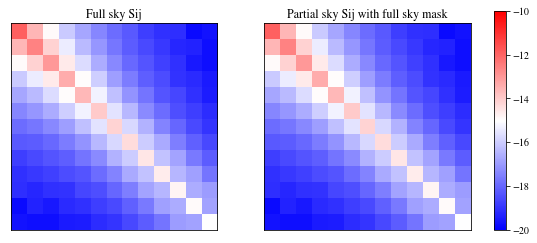

In [5]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,3.5))
im = axes[0].imshow(np.log(abs(Sijw_full)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
im2 = axes[1].imshow(np.log(abs(Sijw_part)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sij')
axes[1].set_title('Partial sky Sij with full sky mask')
fig.subplots_adjust(left=0.02,bottom=0.08,top=0.9,wspace=0.002)
cbar_ax = fig.add_axes([0.9, 0.08, 0.02, 0.87])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

100.0% of the part sky Sij bins are within 1% of the Sij full sky value


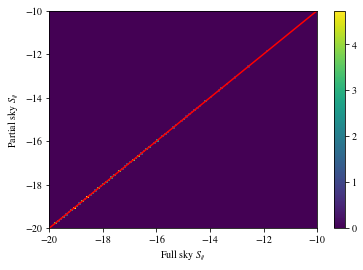

In [6]:
plt.figure()
plt.hist2d(np.log(abs(Sijw_full)).flatten(),np.log(abs(Sijw_part)).flatten(),bins=100,density=True,range=[[-20,-10],[-20,-10]])
plt.plot(np.linspace(-20,-10,100),np.linspace(-20,-10,100),color='r')
plt.xlabel(r'Full sky $S_{ij}$')
plt.ylabel(r'Partial sky $S_{ij}$')
plt.colorbar()

diff = (np.log(abs(Sijw_full)) - np.log(abs(Sijw_part)))/np.log(abs(Sijw_full)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=1.)/nbins_T**2 *100))

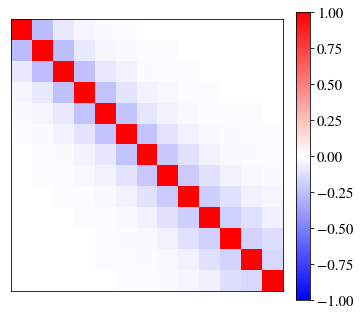

-0.257905652421742


In [23]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_full = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_full[i,j] = Sijw_full[i,j] / np.sqrt(Sijw_full[i,i]*Sijw_full[j,j])
#Plot it
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correlw_full,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correlw_full.min())

## Partial sky Sij for DES mask

In [24]:
t0 = time.clock()
Sijw_part_DES = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/DES-mask-simple-ring-1024.fits',verbose=True)
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
f_sky = 0.1207
lmax = 32
Computed in 2.4 minutes


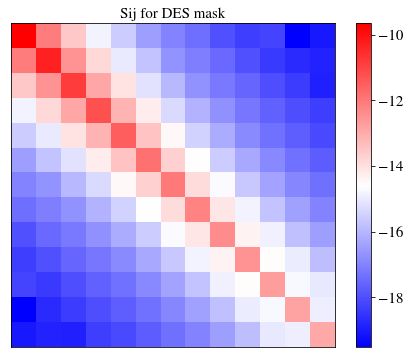

In [9]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_DES)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for DES mask',fontsize=15)
plt.show()

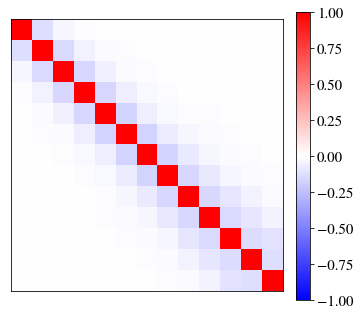

-0.17166698980868392


In [15]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_part_DES = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_DES[i,j] = Sijw_part_DES[i,j] / np.sqrt(Sijw_part_DES[i,i]*Sijw_part_DES[j,j])
#Plot it
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correlw_part_DES,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correlw_part_DES.min())

## Partial sky Sij for Euclid mask

In [4]:
t0 = time.clock()
Sijw_part_Euclid = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/Euclid_map_WIDE_SURVEY.fits',verbose=True)
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
f_sky = 0.3762
lmax = 27
Computed in 0.8 minutes


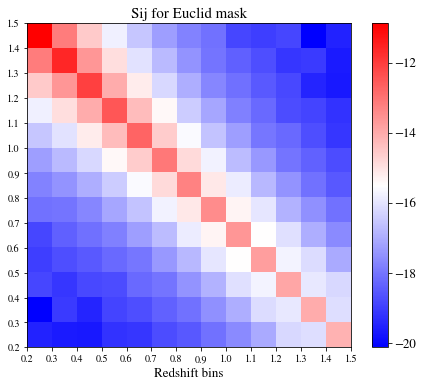

In [12]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijw_part_Euclid)),interpolation='none',cmap='bwr',extent=(zmin,zmax,zmin,zmax)) 
plt.xlabel(r'Redshift bins',fontsize=13) 
plt.xticks(zstakes) 
plt.yticks(zstakes)
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=13) 
ax.set_title('Sij for Euclid mask',fontsize=15)
plt.show()

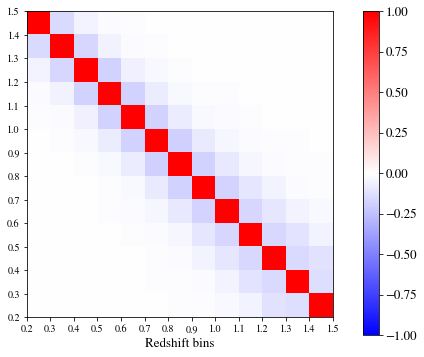

-0.1817668227431102


In [9]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_part_Euclid = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_Euclid[i,j] = Sijw_part_Euclid[i,j] / np.sqrt(Sijw_part_Euclid[i,i]*Sijw_part_Euclid[j,j])
#Plot it
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(correlw_part_Euclid,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=(zmin,zmax,zmin,zmax)) 
plt.xlabel(r'Redshift bins',fontsize=13) 
plt.xticks(zstakes) 
plt.yticks(zstakes)
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=13)
plt.show()
print(correlw_part_Euclid.min())

## Partial sky Sij for 5 degrees patch

In [5]:
t0 = time.clock()
Sijw_part_5d = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/circular-mask_5deg.fits',verbose=True)
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
f_sky = 0.0019
lmax = 136
Computed in 4.1 minutes


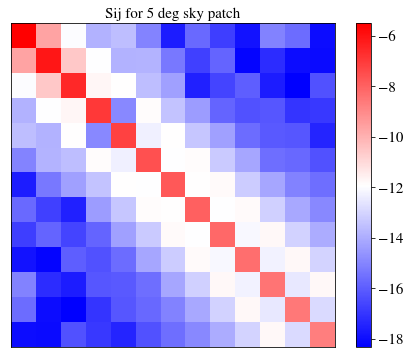

In [21]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_5d)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for 5 deg sky patch',fontsize=15)
plt.show()

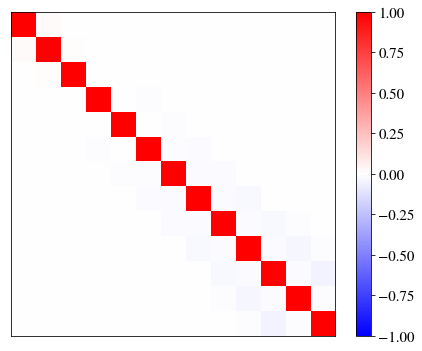

-0.04097177060332938


In [22]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
nzbins          = len(zstakes) - 1
correlw_part_5d = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_5d[i,j] = Sijw_part_5d[i,j] / np.sqrt(Sijw_part_5d[i,i]*Sijw_part_5d[j,j])
#Plot it
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.05,0.75,0.9])
P = ax.imshow(correlw_part_5d,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correlw_part_5d.min())

# Most general case: Sijkl

### Comparison of results for full sky

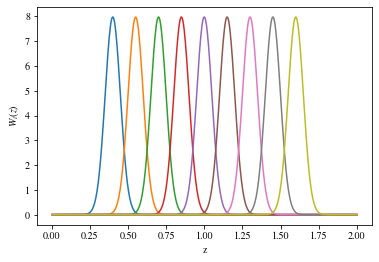

In [17]:
#Top-hat window functions have no interest here, since the cross-spectra would be basically zero
#So we go for Gaussian window functions
sigmaz    = 0.05
zcenter_G = [0.4,0.55,0.7,0.85,1.,1.15,1.3,1.45,1.6]
nbins_G   = len(zcenter_G)
windows_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    windows_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

# Plot window functions
for i in range(nbins_G):
    plt.plot(z_arr,windows_G[i,:])
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

In [35]:
#Top-hat window functions have no interest here, since the cross-spectra would be basically zero
#So we go for Gaussian window functions
t0 = time.clock()
Sijkl_full = PySSC.Sijkl(z_arr,windows_G)
t1 = time.clock()

Sijkl_psky = PySSC.Sijkl_psky(z_arr,windows_G,clmask=None,mask='./masks/full_sky_map.fits',verbose=True)
t2 = time.clock()
print('Sij full sky took: %.1f secs, part sky %.1f secs' %(t1-t0,t2-t1))

Using mask map, given as a fits file
f_sky = 1.0000
lmax = 1
Sij full sky took: 4.0 secs, part sky 24.2 secs


In [22]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count       = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_full_recast = np.zeros((npairs_G,npairs_G))
Sijkl_psky_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_full_recast[ipair,jpair] = Sijkl_full[ibin,jbin,kbin,lbin]
        Sijkl_psky_recast[ipair,jpair] = Sijkl_psky[ibin,jbin,kbin,lbin]

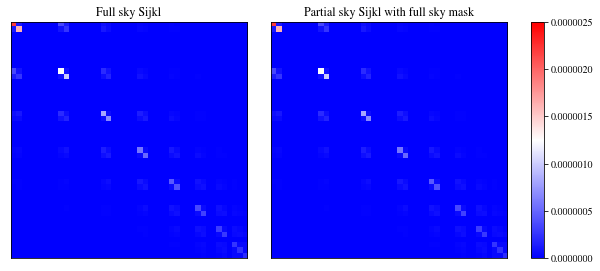

In [32]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(abs(Sijkl_full_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=0,vmax=2.5e-6)
im2 = axes[1].imshow(abs(Sijkl_psky_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=0,vmax=2.5e-6)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl with full sky mask')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

In [47]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast)==0)[0]
Sijkl_psky_recast_valid = np.delete(np.delete(Sijkl_psky_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid.shape[0]
print(nvalid)
invalid_list         = np.where(np.diag(Sijkl_full_recast)==0)[0]
Sijkl_full_recast_valid = np.delete(np.delete(Sijkl_full_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_full_recast_valid.shape[0]
print(nvalid)

17
17


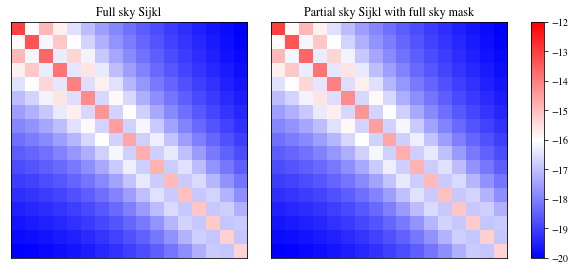

In [61]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(np.log(abs(Sijkl_full_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
im2 = axes[1].imshow(np.log(abs(Sijkl_psky_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl with full sky mask')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

100.0% of the part sky Sij bins are within 1% of the Sij full sky value


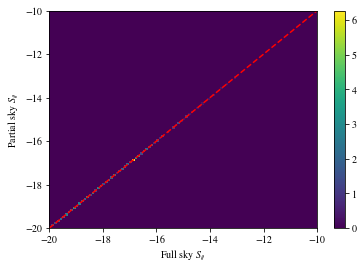

In [54]:
plt.figure()
plt.hist2d(np.log(abs(Sijkl_full_recast_valid)).flatten(),np.log(abs(Sijkl_psky_recast_valid)).flatten(),bins=100,density=True,range=[[-20,-10],[-20,-10]])
plt.plot(np.linspace(-20,-10,100),np.linspace(-20,-10,100),color='r',ls='--')
plt.xlabel(r'Full sky $S_{ij}$')
plt.ylabel(r'Partial sky $S_{ij}$')
plt.colorbar()

diff = (np.log(abs(Sijkl_full_recast_valid)) - np.log(abs(Sijkl_psky_recast_valid)))/np.log(abs(Sijkl_full_recast_valid)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=1.)/nvalid**2 *100))

### Example: Partial sky Sijkl with Euclid mask

In [38]:
t0 = time.clock()
Sijkl_pskyE = PySSC.Sijkl_psky(z_arr,windows_G,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits',verbose=True)
t1 = time.clock()
print('Sij part sky computed in %.1f mins' %((t1-t0)/60))

Using mask map, given as a fits file
f_sky = 0.3762
lmax = 101
Sij part sky computed in 343.8 secs


In [39]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count       = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_pskyE_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_pskyE_recast[ipair,jpair] = Sijkl_pskyE[ibin,jbin,kbin,lbin]


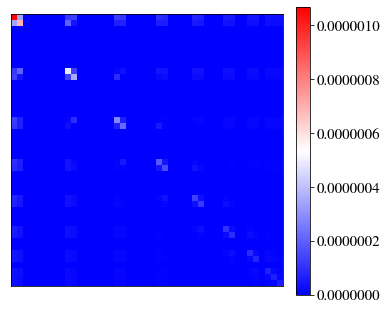

In [41]:
#Plot |Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(abs(Sijkl_pskyE_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

In [45]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_pskyE_recast)==0)[0]
Sijkl_pskyE_recast_valid = np.delete(np.delete(Sijkl_pskyE_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_pskyE_recast_valid.shape[0]

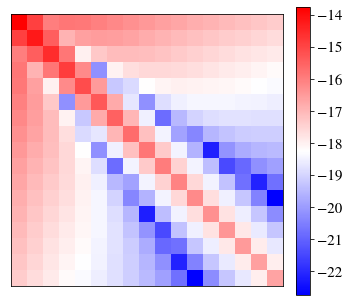

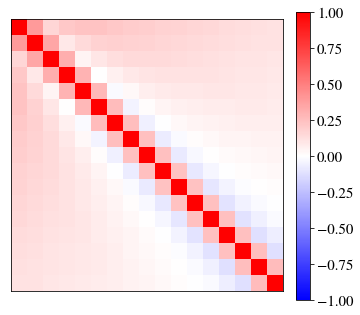

-0.1233222548884952


In [46]:
#Plot ln|Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijkl_pskyE_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_ijkl_pskyE= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_pskyE[i,j] = Sijkl_pskyE_recast_valid[i,j] / np.sqrt(Sijkl_pskyE_recast_valid[i,i]*Sijkl_pskyE_recast_valid[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_ijkl_pskyE,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl_ijkl_pskyE.min())

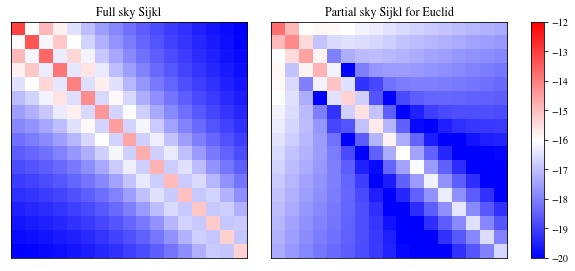

In [60]:
# Compare to full sky
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(np.log(abs(Sijkl_full_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
im2 = axes[1].imshow(np.log(abs(Sijkl_pskyE_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl for Euclid')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

# Euclid redshift bins

## Photometric bins

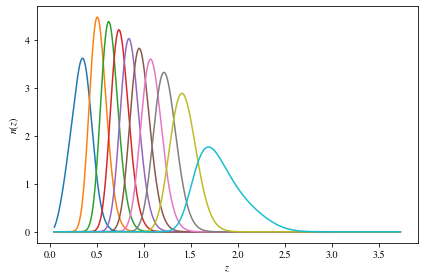

[0.35   0.5065 0.628  0.737  0.843  0.9525 1.0735 1.217  1.408  1.691 ]


In [103]:
zarr = np.loadtxt('./n_z_without_1_plus_z.dat',unpack=True,usecols=(0))[100:]
window = np.loadtxt('./n_z_without_1_plus_z.dat',unpack=True,usecols=(1,2,3,4,5,6,7,8,9,10))[:,100:]
nbins = window.shape[0]
zbins = zarr[np.argmax(window,axis=1)]
plt.figure()
for u,zbin in enumerate(window):
	plt.plot(zarr,zbin)
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')
# plt.legend(frameon='False',loc='best')
plt.tight_layout()
plt.savefig('n_z_Euclid.png')
plt.show()
print(zbins)

In [104]:
# partial sky Sijkl with Euclid mask
t1 = time.clock()
print('Computing partial sky Sijkl for Euclid...')
Sijkl1 = PySSC.Sijkl_psky(zarr,window,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits') 
t2 = time.clock()
print('Sij took %.1f mins' %((t2-t1)/60))

Computing partial sky Sijkl for Euclid...
Sij took 3.4 mins


39


Text(0.5, 1.0, 'Sijkl for Euclid')

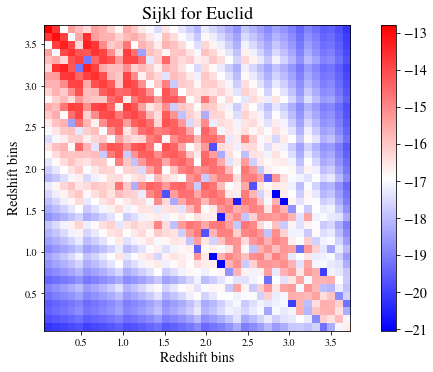

In [105]:
#Build indexing of pairs of redshift bins
npairs = (nbins*(nbins+1))//2
pairs  = np.zeros((2,npairs),dtype=int)
count       = 0
for ibin in range(nbins):
    for jbin in range(ibin,nbins):
        pairs[0,count] = ibin
        pairs[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_psky_recast = np.zeros((npairs,npairs))
for ipair in range(npairs):
    ibin = pairs[0,ipair]
    jbin = pairs[1,ipair]
    for jpair in range(npairs):
        kbin = pairs[0,jpair]
        lbin = pairs[1,jpair]
        Sijkl_psky_recast[ipair,jpair] = Sijkl1[ibin,jbin,kbin,lbin]

#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast)==0)[0]
Sijkl_psky_recast_valid = np.delete(np.delete(Sijkl_psky_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid.shape[0]
print(nvalid)

fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijkl_psky_recast_valid)),interpolation='none',cmap='bwr',extent=(np.min(zarr),np.max(zarr),np.min(zarr),np.max(zarr))) 
plt.xlabel(r'Redshift bins',fontsize=14); plt.ylabel(r'Redshift bins',fontsize=14)
# for zbin in zbins:
#     plt.axvline(zbin,color='k')
#     plt.axhline(zbin,color='k')
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=14) 
ax.set_title('Sijkl for Euclid',fontsize=18)

-0.1983529889771182


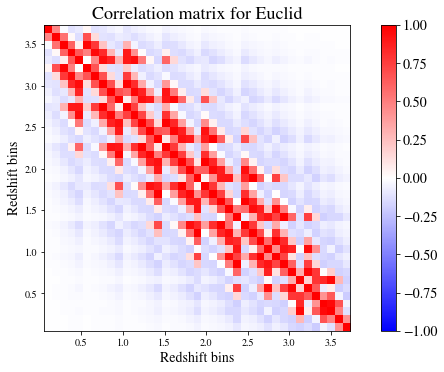

In [106]:
#Second plot the correlation matrix
correl_ijkl_psky= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_psky[i,j] = Sijkl_psky_recast_valid[i,j] / np.sqrt(Sijkl_psky_recast_valid[i,i]*Sijkl_psky_recast_valid[j,j])

fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(correl_ijkl_psky,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[np.min(zarr),np.max(zarr),np.min(zarr),np.max(zarr)]) 
plt.xlabel(r'Redshift bins',fontsize=14); plt.ylabel(r'Redshift bins',fontsize=14) 
plt.title('Correlation matrix for Euclid',fontsize=18)
# ax2 = ax.twinx()
# for zbin in window:
#     ax2.plot(zarr,zbin,color='k',lw=.8)
# P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=14)
print(correl_ijkl_psky.min())
plt.savefig('Correlation_matrix_Euclid_photo.png')

## Spectrometry

In [107]:
#GCs
zmins = np.array([0.90,1.10,1.30,1.50])
zmaxs = np.array([1.10,1.30,1.50,1.80])
n_zs = np.array([6.86,5.58,4.21,2.61])* 1e-4
zbins = np.array([1.00,1.20,1.40,1.65])
zmin = np.min(zmins) ; zmax = np.max(zmaxs)
zstakes    = np.r_[zmins,zmaxs[-1]]

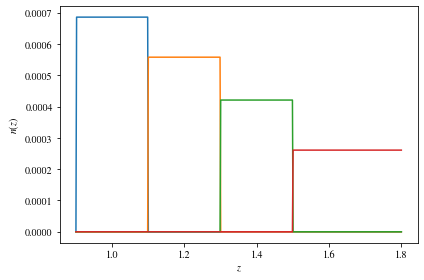

In [108]:
# Define redshift range
nz       = 500
z_arr    = np.linspace(zmin,zmax,num=nz)

nbins2   = zmins.size
windows2 = np.zeros((nbins2,nz))
for i in range(nbins2):
    zminbin = zmins[i] ; zmaxbin = zmaxs[i] ; Dz = zmaxbin-zminbin
    for iz,z in enumerate(z_arr):
        if ((z>zminbin) and (z<=zmaxbin)):
            windows2[i,iz] = n_zs[i]

plt.figure()
for i in range(nbins2):   
    plt.plot(z_arr,windows2[i,:])
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')
plt.tight_layout()
# plt.savefig('n_z_Euclid_Gcs.png')

In [109]:
# partial sky Sijkl with Euclid mask
t1 = time.clock()
print('Computing partial sky Sijkl for Euclid...')
Sijkl2 = PySSC.Sijkl_psky(z_arr,windows2,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits') 
t2 = time.clock()
print('Sijkl took %.1f secs' %(t2-t1))

Computing partial sky Sijkl for Euclid...
Sijkl took 20.4 secs


4
0.9 1.8


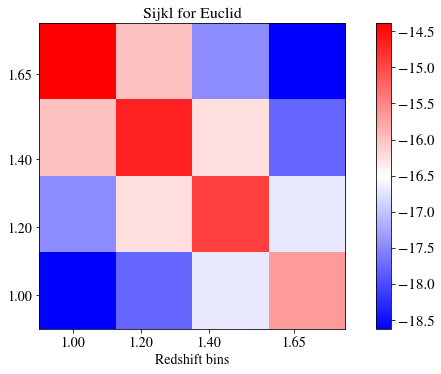

In [110]:
#Build indexing of pairs of redshift bins
npairs = (nbins2*(nbins2+1))//2
pairs  = np.zeros((2,npairs),dtype=int)
count       = 0
for ibin in range(nbins2):
    for jbin in range(ibin,nbins2):
        pairs[0,count] = ibin
        pairs[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_psky_recast2 = np.zeros((npairs,npairs))
for ipair in range(npairs):
    ibin = pairs[0,ipair]
    jbin = pairs[1,ipair]
    for jpair in range(npairs):
        kbin = pairs[0,jpair]
        lbin = pairs[1,jpair]
        Sijkl_psky_recast2[ipair,jpair] = Sijkl2[ibin,jbin,kbin,lbin]

#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast2)==0)[0]
Sijkl_psky_recast_valid2 = np.delete(np.delete(Sijkl_psky_recast2,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid2.shape[0]
print(nvalid)

fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijkl_psky_recast_valid2)),interpolation='none',cmap='bwr',extent=(zmin,zmax,zmin,zmax)) 
plt.xlabel(r'Redshift bins',fontsize=14) 
plt.xticks(zbins,fontsize=14); plt.yticks(zbins,fontsize=14)
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sijkl for Euclid',fontsize=16)
print(zmin,zmax)

-0.24501865751785418


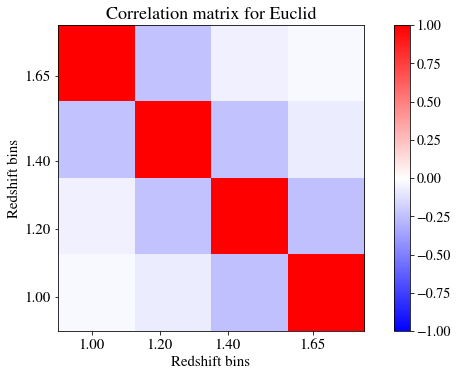

In [111]:
#Second plot the correlation matrix
correl_ijkl_psky2= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_psky2[i,j] = Sijkl_psky_recast_valid2[i,j] / np.sqrt(Sijkl_psky_recast_valid2[i,i]*Sijkl_psky_recast_valid2[j,j])

fig = plt.figure(figsize=(6.,5))
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(correl_ijkl_psky2,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmin,zmax])
plt.xlabel(r'Redshift bins',fontsize=15); plt.ylabel(r'Redshift bins',fontsize=15) 
plt.xticks(zbins,fontsize=14); plt.yticks(zbins,fontsize=14)
plt.title('Correlation matrix for Euclid',fontsize=18)
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=14)
print(correl_ijkl_psky2.min())
plt.savefig('Correlation_matrix_Euclid_spectro.png')